## IDMB Data
https://www.kaggle.com/datasets/mahmoudshaheen1134/imdp-data

In [1]:
import pandas as pd
from pycaret.classification import *
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
import kagglehub
import os

In [2]:
def prepare_data(file_path, sample_size=None):
    """
    Load and prepare the IMDB dataset with text preprocessing
    """
    # Download required NLTK data
    nltk.download('stopwords')

    print("Path to dataset files:", file_path)
    # Read the dataset
    df = pd.read_csv(file_path)
    
    # Take a sample if specified (useful for quick testing)
    if sample_size:
        df = df.sample(n=sample_size, random_state=42).reset_index(drop=True)
    
    # Create TF-IDF features with stopword removal
    tfidf = TfidfVectorizer(
        stop_words='english',
        max_features=5000,
        strip_accents='unicode',
        lowercase=True
    )
    
    # Transform the text data
    text_features = tfidf.fit_transform(df['review'])
    
    # Convert to DataFrame
    feature_names = tfidf.get_feature_names_out()
    text_df = pd.DataFrame(text_features.toarray(), columns=feature_names)
    
    # Combine with target variable
    final_df = pd.concat([text_df, df['sentiment']], axis=1)
    
    return final_df

In [3]:
def setup_pycaret_classifier(data):
    """
    Setup PyCaret classification experiment
    """
    # Initialize setup with minimal parameters
    clf_setup = setup(
        data=data,
        target='sentiment',
        session_id=42,
        preprocess=True,
        n_jobs=4
    )
    return clf_setup

In [4]:
def get_best_models(top_n=3):
    """
    Get the best performing models
    """
    print(f"\nTraining and selecting top {top_n} models...")
    best_models = compare_models(
        n_select=top_n,
        sort='F1' # Using F1 as initial metric since it balances Precision and Recall
    )
    return best_models

In [5]:
def tune_models(models):
    """
    Fine-tune each model using PyCaret's tune_model function
    Optimizing for both Precision and Recall
    """
    print("\nTuning individual models...")
    tuned_models = []
    
    for i, model in enumerate(models, 1):
        print(f"\nTuning model {i}...")
        
        # Print available metrics before tuning
        print("\nAvailable metrics before tuning:")
        initial_metrics = pull()
        print(initial_metrics.columns.tolist())
        
        # First tune for Recall
        print(f"\nTuning for Recall...")
        recall_tuned = tune_model(
            model,
            n_iter=10,
            optimize='Recall',
            search_library='optuna',
            choose_better=True
        )
        
        # Then tune for Precision
        print(f"\nTuning for Precision...")
        precision_tuned = tune_model(
            recall_tuned,
            n_iter=10,
            optimize='Prec.',  # or whatever the actual precision metric name is
            search_library='optuna',
            choose_better=True
        )
        
        print(f"\nModel {i} tuning completed")
        
        # Print final metrics
        print("\nFinal metrics after tuning:")
        eval_metrics = pull()
        for metric in eval_metrics.columns:
            try:
                print(f"{metric}: {eval_metrics.loc[0, metric]:.4f}")
            except:
                print(f"{metric}: {eval_metrics.loc[0, metric]}")
        
        tuned_models.append(precision_tuned)
    
    return tuned_models

In [6]:
def create_ensemble(tuned_models):
    """
    Create a stacking ensemble from the tuned models
    """
    print("\nCreating stacking ensemble...")
    
    # Crear el meta-modelo con PyCaret
    lr_meta_model = create_model('xgboost')

    # Crear stacking ensemble con el meta-modelo 
    stacker = stack_models(
        estimator_list=tuned_models,
        meta_model=lr_meta_model,  # Aquí ya es un modelo con método fit()
        restack=True
    )

    return stacker


In [7]:
def evaluate_model(model, model_name="Model"):
    """
    Evaluate model performance with focus on Precision and Recall
    """
    print(f"\nEvaluating {model_name}...")
    
    # Get model predictions
    predictions = predict_model(model)
    
    # Create evaluation plots
    try:
        plot_model(model, plot='confusion_matrix')
        plot_model(model, plot='pr')  # Precision-Recall curve
    except:
        print("Warning: Could not create some plots")
    
    # Print detailed metrics
    try:
        metrics = pull()
        print("\nDetailed Metrics:")
        
        # Get the actual column names from the metrics DataFrame
        metric_columns = metrics.columns
        
        # Print available metrics
        for metric in metric_columns:
            try:
                print(f"{metric}: {metrics.loc[0, metric]:.4f}")
            except:
                print(f"{metric}: {metrics.loc[0, metric]}")
    except Exception as e:
        print(f"Error getting metrics: {str(e)}")
    
    return predictions

In [8]:
def compare_performances(tuned_models, ensemble_model):
    """
    Compare performance of individual models against ensemble
    """
    print("\n=== PERFORMANCE COMPARISON ===")
    print("\nIndividual Models Performance:")
    
    # Store metrics for comparison
    all_metrics = []
    
    # Evaluate individual models
    for i, model in enumerate(tuned_models, 1):
        print(f"\nModel {i}:")
        predictions = predict_model(model)
        metrics = pull()
        all_metrics.append(metrics.iloc[0].to_dict())
        
        # Print all available metrics
        for col in metrics.columns:
            try:
                print(f"{col}: {metrics.iloc[0][col]:.4f}")
            except:
                print(f"{col}: {metrics.iloc[0][col]}")
    
    # Evaluate ensemble
    print("\nEnsemble Model Performance:")
    ensemble_predictions = predict_model(ensemble_model)
    ensemble_metrics = pull()
    
    # Print all available metrics for ensemble
    for col in ensemble_metrics.columns:
        try:
            print(f"{col}: {ensemble_metrics.iloc[0][col]:.4f}")
        except:
            print(f"{col}: {ensemble_metrics.iloc[0][col]}")
    
    # Compare with best individual model
    print("\n=== COMPARISON WITH BEST INDIVIDUAL MODEL ===")
    for col in ensemble_metrics.columns:
        if col in all_metrics[0]:  # Check if metric exists in individual models
            best_individual = max(m[col] for m in all_metrics if isinstance(m[col], (int, float)))
            ensemble_value = ensemble_metrics.iloc[0][col]
            
            try:
                print(f"{col}:")
                print(f"Best Individual: {best_individual:.4f}")
                print(f"Ensemble: {ensemble_value:.4f}")
                if isinstance(ensemble_value, (int, float)):
                    improvement = ((ensemble_value - best_individual) / best_individual) * 100
                    print(f"Improvement: {improvement:.2f}%")
                print()
            except:
                continue

    return ensemble_predictions


In [9]:
# Load and prepare data
print("Loading and preparing data...")
# data = prepare_data('IMDB Dataset.csv', sample_size=100)
data = prepare_data('IMDB Dataset.csv')

# Setup the classification experiment
print("Setting up PyCaret classifier...")
clf_setup = setup_pycaret_classifier(data)

# Get best individual models
best_models = get_best_models(top_n=2)

Loading and preparing data...
Path to dataset files: IMDB Dataset.csv


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafae\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Setting up PyCaret classifier...


,Description,Value
0,Session id,42
1,Target,sentiment
2,Target type,Binary
3,Target mapping,"negative: 0, positive: 1"
4,Original data shape,"(50000, 5001)"
5,Transformed data shape,"(50000, 5001)"
6,Transformed train set shape,"(35000, 5001)"
7,Transformed test set shape,"(15000, 5001)"
8,Numeric features,5000
9,Preprocess,True



Training and selecting top 2 models...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8840,0.9526,0.8840,0.8843,0.8840,0.7680,0.7683,5.9070
svm,SVM - Linear Kernel,0.8785,0.9522,0.8785,0.8811,0.8783,0.7570,0.7596,3.3230
ridge,Ridge Classifier,0.8754,0.9467,0.8754,0.8757,0.8753,0.7507,0.7511,3.5510
catboost,CatBoost Classifier,0.8680,0.9421,0.8680,0.8688,0.8680,0.7361,0.7368,137.0530
lda,Linear Discriminant Analysis,0.8641,0.9378,0.8641,0.8643,0.8641,0.7282,0.7284,22.9920
et,Extra Trees Classifier,0.8628,0.9360,0.8628,0.8631,0.8627,0.7255,0.7259,20.4100
lightgbm,Light Gradient Boosting Machine,0.8554,0.9345,0.8554,0.8558,0.8554,0.7109,0.7112,6.9040
xgboost,Extreme Gradient Boosting,0.8501,0.9293,0.8501,0.8509,0.8500,0.7002,0.7010,16.0690
rf,Random Forest Classifier,0.8456,0.9240,0.8456,0.8458,0.8455,0.6911,0.6914,10.5670
gbc,Gradient Boosting Classifier,0.8054,0.8918,0.8054,0.8100,0.8047,0.6109,0.6154,53.5210



Initial model performances:

Model 1 - Initial Performance:

Evaluating Initial Model 1...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8891,0.9562,0.8891,0.8892,0.8891,0.7781,0.7783


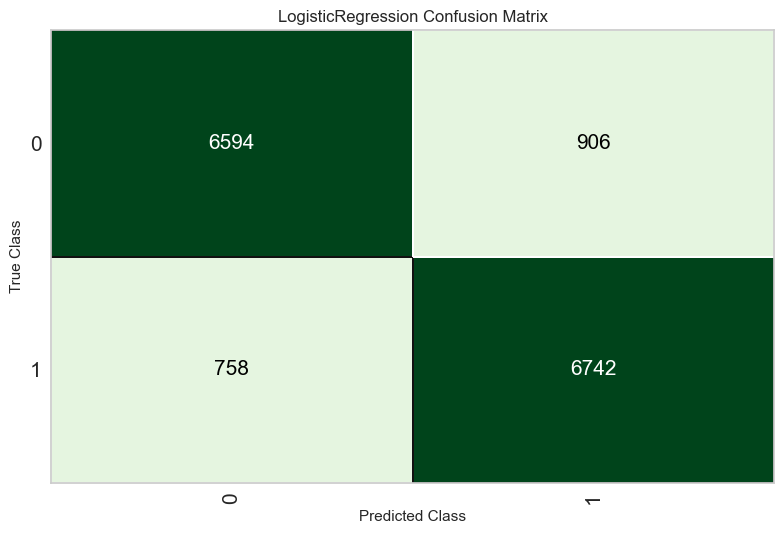

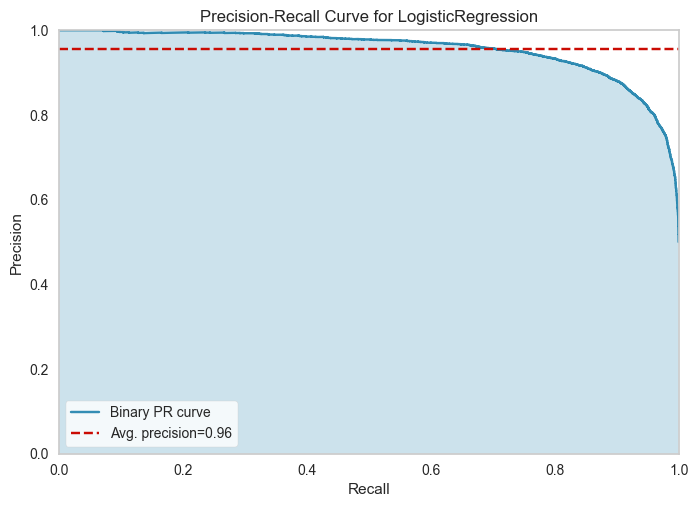


Detailed Metrics:
Model: Logistic Regression
Accuracy: 0.8891
AUC: 0.9562
Recall: 0.8891
Prec.: 0.8892
F1: 0.8891
Kappa: 0.7781
MCC: 0.7783

Model 2 - Initial Performance:

Evaluating Initial Model 2...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8878,0,0.8878,0.8878,0.8878,0.7756,0.7756


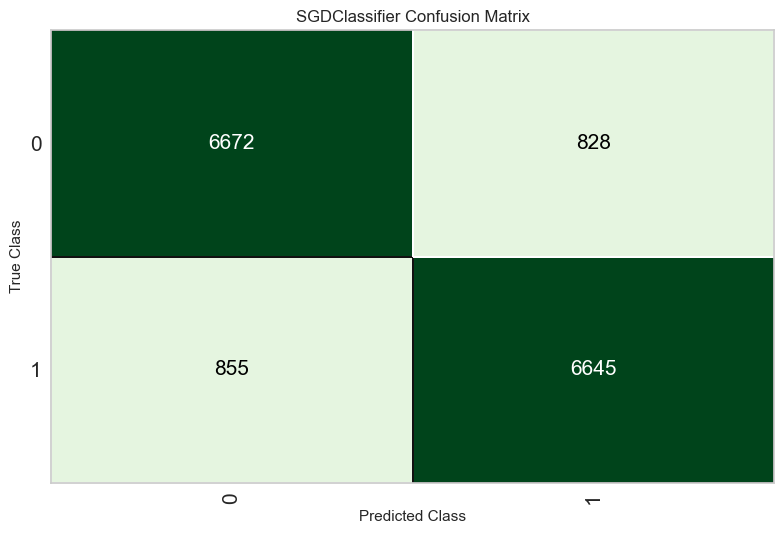

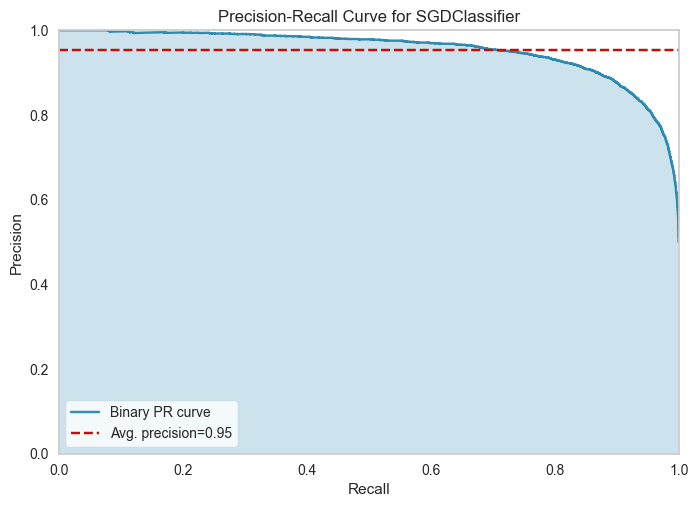


Detailed Metrics:
Model: SVM - Linear Kernel
Accuracy: 0.8878
AUC: 0.0000
Recall: 0.8878
Prec.: 0.8878
F1: 0.8878
Kappa: 0.7756
MCC: 0.7756


In [10]:
# Print initial model performances
print("\nInitial model performances:")
for i, model in enumerate(best_models, 1):
    print(f"\nModel {i} - Initial Performance:")
    evaluate_model(model, f"Initial Model {i}")

In [11]:
# Tune the models
tuned_models = tune_models(best_models)


Tuning individual models...

Tuning model 1...

Available metrics before tuning:
['Model', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']

Tuning for Recall...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8806,0.9515,0.8806,0.8813,0.8805,0.7611,0.7619
1,0.8843,0.9496,0.8843,0.8843,0.8843,0.7686,0.7686
2,0.8826,0.9510,0.8826,0.8826,0.8826,0.7651,0.7652
3,0.8774,0.9476,0.8774,0.8776,0.8774,0.7549,0.7550
4,0.8897,0.9554,0.8897,0.8899,0.8897,0.7794,0.7796
5,0.8863,0.9528,0.8863,0.8863,0.8863,0.7726,0.7726
6,0.8880,0.9543,0.8880,0.8889,0.8879,0.7760,0.7769
7,0.8831,0.9536,0.8831,0.8833,0.8831,0.7663,0.7664
8,0.8891,0.9575,0.8891,0.8894,0.8891,0.7783,0.7786



Tuning for Precision...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8769,0.9515,0.8769,0.8774,0.8768,0.7537,0.7543
1,0.8826,0.9494,0.8826,0.8826,0.8826,0.7651,0.7651
2,0.8823,0.9515,0.8823,0.8823,0.8823,0.7646,0.7646
3,0.8754,0.9480,0.8754,0.8755,0.8754,0.7509,0.7509
4,0.8929,0.9553,0.8929,0.8930,0.8928,0.7857,0.7858
5,0.8860,0.9531,0.8860,0.8860,0.8860,0.7720,0.7720
6,0.8869,0.9537,0.8869,0.8875,0.8868,0.7737,0.7744
7,0.8803,0.9537,0.8803,0.8804,0.8803,0.7606,0.7606
8,0.8854,0.9570,0.8854,0.8860,0.8854,0.7709,0.7714


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Model 1 tuning completed

Final metrics after tuning:
Accuracy: 0.8769
AUC: 0.9515
Recall: 0.8769
Prec.: 0.8774
F1: 0.8768
Kappa: 0.7537
MCC: 0.7543

Tuning model 2...

Available metrics before tuning:
['Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC']

Tuning for Recall...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8789,0.9501,0.8789,0.8794,0.8788,0.7577,0.7582
1,0.8789,0.9489,0.8789,0.8790,0.8788,0.7577,0.7578
2,0.8800,0.9477,0.8800,0.8800,0.8800,0.7600,0.7600
3,0.8740,0.9454,0.8740,0.8744,0.8740,0.7480,0.7484
4,0.8900,0.9536,0.8900,0.8904,0.8900,0.7800,0.7804
5,0.8843,0.9503,0.8843,0.8845,0.8843,0.7686,0.7687
6,0.8869,0.9524,0.8869,0.8878,0.8868,0.7737,0.7747
7,0.8826,0.9511,0.8826,0.8827,0.8826,0.7651,0.7653
8,0.8906,0.9563,0.8906,0.8910,0.8905,0.7811,0.7816



Tuning for Precision...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8786,0.9519,0.8786,0.8794,0.8785,0.7571,0.7580
1,0.8829,0.9502,0.8829,0.8830,0.8828,0.7657,0.7659
2,0.8797,0.9504,0.8797,0.8798,0.8797,0.7594,0.7595
3,0.8760,0.9475,0.8760,0.8769,0.8759,0.7520,0.7529
4,0.8926,0.9549,0.8926,0.8931,0.8925,0.7851,0.7857
5,0.8874,0.9520,0.8874,0.8876,0.8874,0.7749,0.7750
6,0.8869,0.9534,0.8869,0.8878,0.8868,0.7737,0.7747
7,0.8820,0.9530,0.8820,0.8822,0.8820,0.7640,0.7642
8,0.8949,0.9579,0.8949,0.8952,0.8948,0.7897,0.7901



Model 2 tuning completed

Final metrics after tuning:
Accuracy: 0.8786
AUC: 0.9519
Recall: 0.8786
Prec.: 0.8794
F1: 0.8785
Kappa: 0.7571
MCC: 0.7580



Tuned model performances:

Model 1 - Tuned Performance:

Evaluating Tuned Model 1...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8897,0.9564,0.8897,0.8899,0.8897,0.7795,0.7796


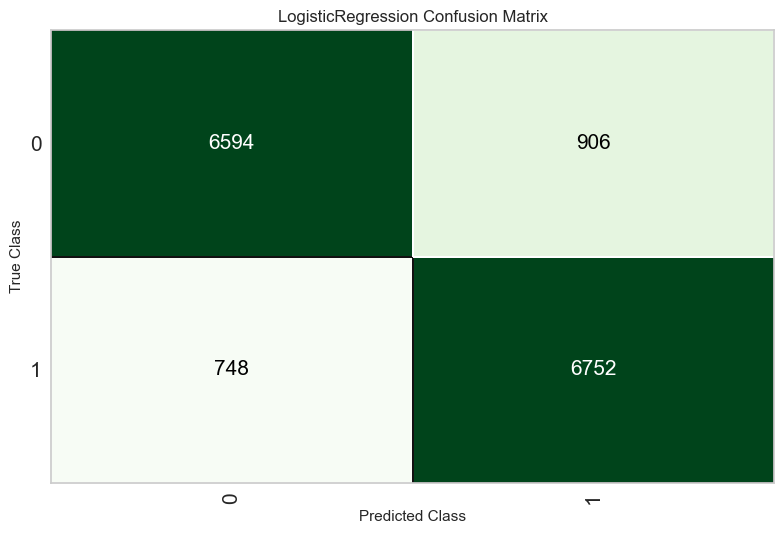

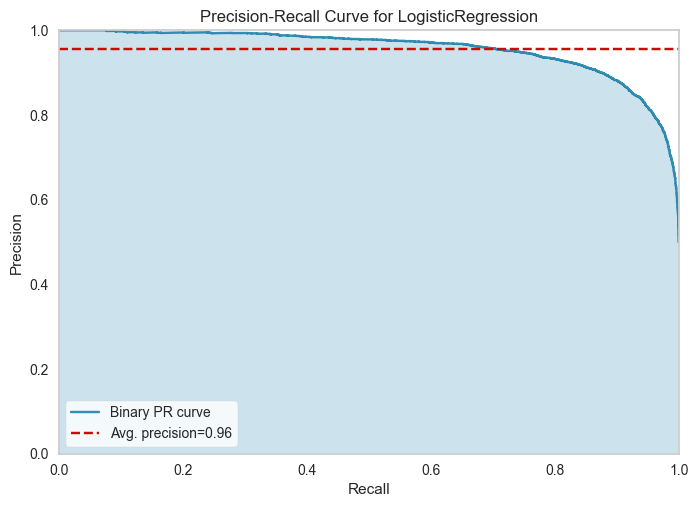


Detailed Metrics:
Model: Logistic Regression
Accuracy: 0.8897
AUC: 0.9564
Recall: 0.8897
Prec.: 0.8899
F1: 0.8897
Kappa: 0.7795
MCC: 0.7796

Model 2 - Tuned Performance:

Evaluating Tuned Model 2...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.8859,0,0.8859,0.8866,0.8858,0.7717,0.7724


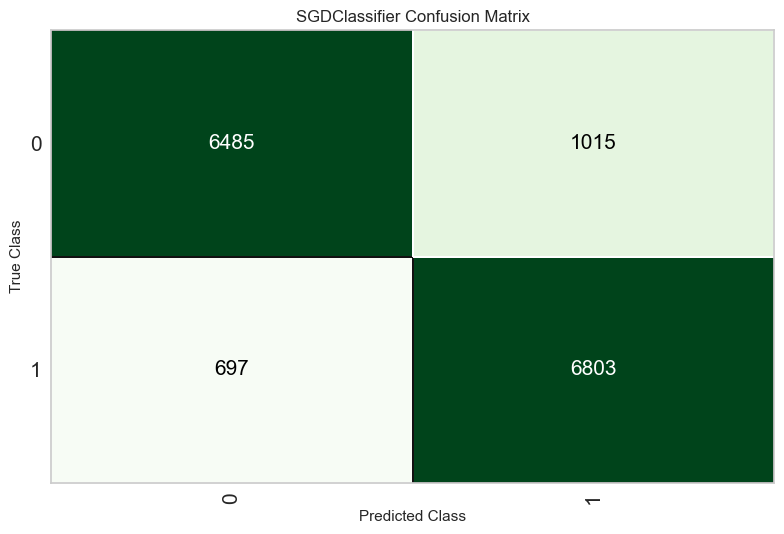

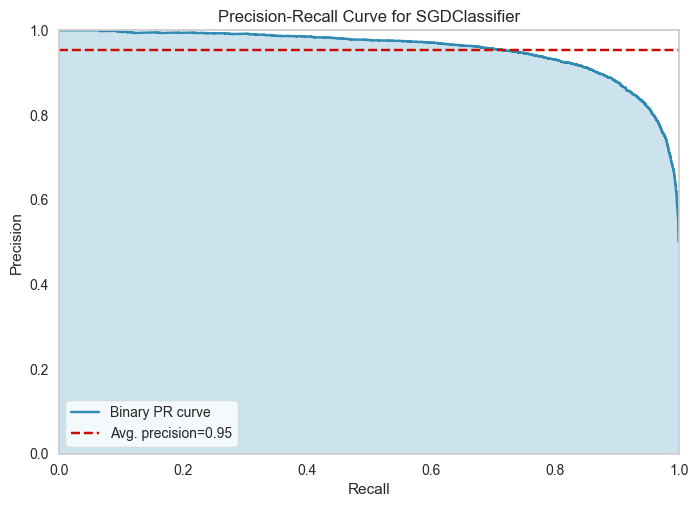


Detailed Metrics:
Model: SVM - Linear Kernel
Accuracy: 0.8859
AUC: 0.0000
Recall: 0.8859
Prec.: 0.8866
F1: 0.8858
Kappa: 0.7717
MCC: 0.7724


In [12]:
# Print tuned model performances
print("\nTuned model performances:")
for i, model in enumerate(tuned_models, 1):
    print(f"\nModel {i} - Tuned Performance:")
    evaluate_model(model, f"Tuned Model {i}")



Creating stacking ensemble...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8443,0.9273,0.8443,0.8450,0.8442,0.6886,0.6893
1,0.8483,0.9269,0.8483,0.8487,0.8482,0.6966,0.6969
2,0.8454,0.9256,0.8454,0.8458,0.8454,0.6909,0.6913
3,0.8437,0.9214,0.8437,0.8442,0.8437,0.6874,0.6880
4,0.8551,0.9316,0.8551,0.8561,0.8550,0.7103,0.7112
5,0.8537,0.9320,0.8537,0.8545,0.8536,0.7074,0.7082
6,0.8506,0.9283,0.8506,0.8524,0.8504,0.7011,0.7030
7,0.8517,0.9335,0.8517,0.8525,0.8516,0.7034,0.7042
8,0.8503,0.9316,0.8503,0.8510,0.8502,0.7006,0.7013


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8829,0.9526,0.8829,0.8831,0.8828,0.7657,0.7660
1,0.8849,0.9496,0.8849,0.8849,0.8849,0.7697,0.7697
2,0.8771,0.9507,0.8771,0.8772,0.8771,0.7543,0.7543
3,0.8800,0.9498,0.8800,0.8802,0.8800,0.7600,0.7602
4,0.8957,0.9548,0.8957,0.8960,0.8957,0.7914,0.7917
5,0.8834,0.9534,0.8834,0.8835,0.8834,0.7669,0.7669
6,0.8849,0.9540,0.8849,0.8856,0.8848,0.7697,0.7705
7,0.8789,0.9532,0.8789,0.8789,0.8789,0.7577,0.7577
8,0.8926,0.9561,0.8926,0.8927,0.8926,0.7851,0.7853



Evaluating Model...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8876,0.9562,0.8876,0.8876,0.8876,0.7752,0.7752


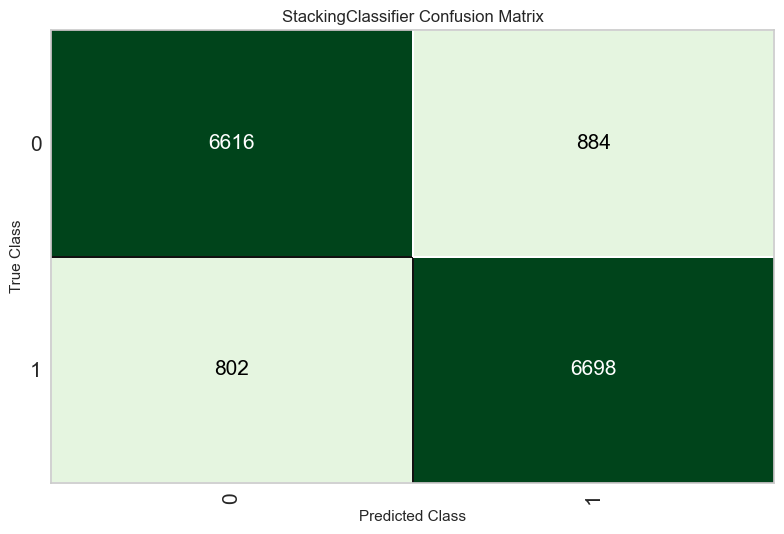

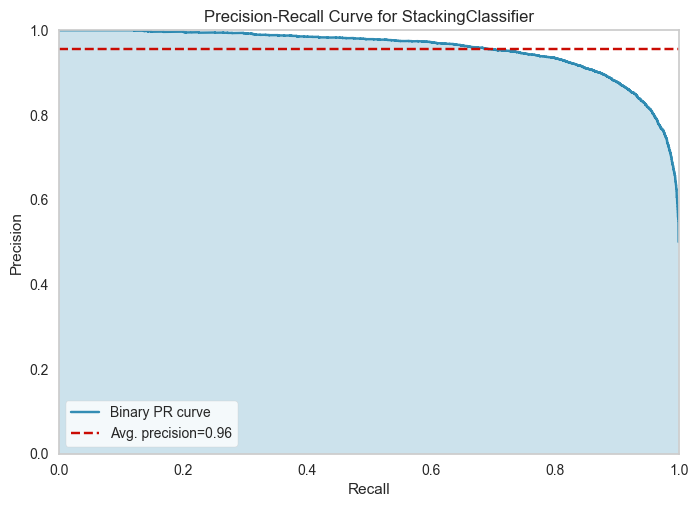


Detailed Metrics:
Model: Stacking Classifier
Accuracy: 0.8876
AUC: 0.9562
Recall: 0.8876
Prec.: 0.8876
F1: 0.8876
Kappa: 0.7752
MCC: 0.7752
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['00', '000', '10', '100', '11',
                                              '12', '13', '13th', '14', '15',
                                              '16', '17', '18', '1930', '1930s',
                                              '1940', '1950', '1950s', '1960',
                                              '1960s', '1968', '1969', '1970...
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                         

In [13]:
# Create the stacking ensemble
stacked_model = create_ensemble(tuned_models)

# Evaluate the stacked model
evaluate_model(stacked_model)

# Save the model
save_model(stacked_model, 'stacked_model')


Creating stacking ensemble...


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8443,0.9273,0.8443,0.8450,0.8442,0.6886,0.6893
1,0.8483,0.9269,0.8483,0.8487,0.8482,0.6966,0.6969
2,0.8454,0.9256,0.8454,0.8458,0.8454,0.6909,0.6913
3,0.8437,0.9214,0.8437,0.8442,0.8437,0.6874,0.6880
4,0.8551,0.9316,0.8551,0.8561,0.8550,0.7103,0.7112
5,0.8537,0.9320,0.8537,0.8545,0.8536,0.7074,0.7082
6,0.8506,0.9283,0.8506,0.8524,0.8504,0.7011,0.7030
7,0.8517,0.9335,0.8517,0.8525,0.8516,0.7034,0.7042
8,0.8503,0.9316,0.8503,0.8510,0.8502,0.7006,0.7013


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8829,0.9526,0.8829,0.8831,0.8828,0.7657,0.7660
1,0.8849,0.9496,0.8849,0.8849,0.8849,0.7697,0.7697
2,0.8771,0.9507,0.8771,0.8772,0.8771,0.7543,0.7543
3,0.8800,0.9498,0.8800,0.8802,0.8800,0.7600,0.7602
4,0.8957,0.9548,0.8957,0.8960,0.8957,0.7914,0.7917
5,0.8834,0.9534,0.8834,0.8835,0.8834,0.7669,0.7669
6,0.8849,0.9540,0.8849,0.8856,0.8848,0.7697,0.7705
7,0.8789,0.9532,0.8789,0.8789,0.8789,0.7577,0.7577
8,0.8926,0.9561,0.8926,0.8927,0.8926,0.7851,0.7853



Evaluating Stacking Ensemble...


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Stacking Classifier,0.8876,0.9562,0.8876,0.8876,0.8876,0.7752,0.7752


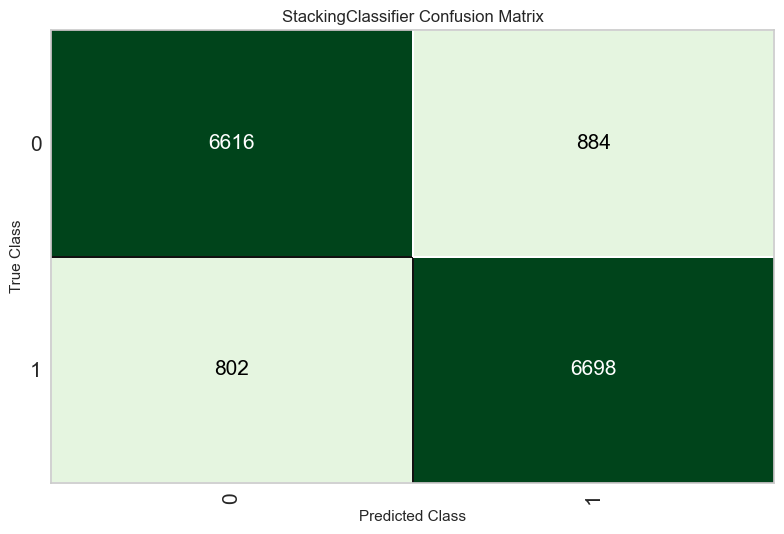

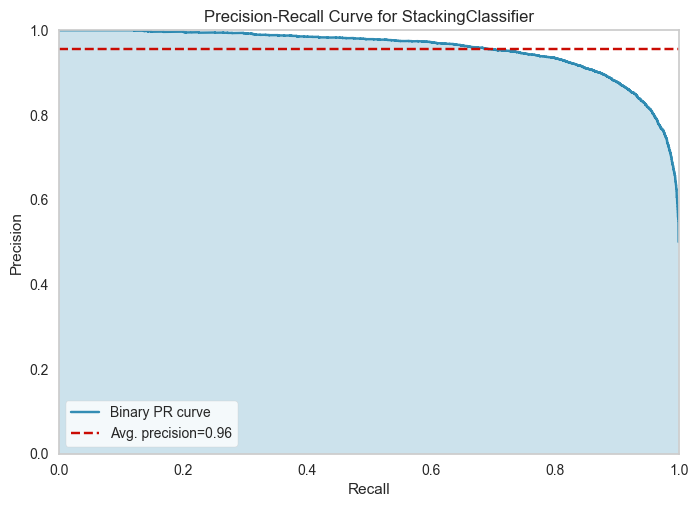


Detailed Metrics:
Model: Stacking Classifier
Accuracy: 0.8876
AUC: 0.9562
Recall: 0.8876
Prec.: 0.8876
F1: 0.8876
Kappa: 0.7752
MCC: 0.7752

Saving ensemble model...
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['00', '000', '10', '100', '11',
                                              '12', '13', '13th', '14', '15',
                                              '16', '17', '18', '1930', '1930s',
                                              '1940', '1950', '1950s', '1960',
                                              '1960s', '1968', '1969', '1970...
                                                                   learning_rate=None,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                         

In [14]:
# Create and evaluate stacking ensemble
stacking_ensemble = create_ensemble(tuned_models)
ensemble_predictions = evaluate_model(stacking_ensemble, "Stacking Ensemble")

# Save the ensemble model
print("\nSaving ensemble model...")
save_model(stacking_ensemble, 'sentiment_classifier_ensemble')